### A CNN classifier for the images from CIFAR 10 dataset

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import os

In [5]:
def check_mem():
    
    mem = os.popen('"C:\\Program Files\\NVIDIA Corporation\\NVSMI\\nvidia-smi" --query-gpu=memory.total,memory.used --format=csv,nounits,noheader').read().split(",")
    
    return mem

def reserve_gpu_memory():
    
    total, used = check_mem()
    
    total = int(total)
    used = int(used)
    
    print(total)
    print(used)
    
    max_mem = int(total * 0.9)
    block_mem = max_mem - used
        
    x = torch.rand((256,1024,block_mem)).cuda()
    x = torch.rand((2,2)).cuda()

In [7]:
# reserve_gpu_memory()
check_mem()

['4096', ' 3964\n']

#### Dowload the CIFAR 10 dataset

In [2]:
trainset = torchvision.datasets.CIFAR10(root='.\datasets', train=True, download=True, transform = transforms.ToTensor())

Files already downloaded and verified


In [3]:
testset = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified


In [4]:
traindataloader = torch.utils.data.DataLoader(trainset, batch_size = 10, num_workers=2, shuffle=True)

In [5]:
testdataloader = torch.utils.data.DataLoader(testset, batch_size = 10, shuffle=True, num_workers = 2)

In [6]:
labels = ('plane', 'car', 'bird', 'cat','deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

#### Analysing the dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
images_batch, labels_batch = iter(traindataloader).next()

In [9]:
img = torchvision.utils.make_grid(images_batch)

In [10]:
img.shape

torch.Size([3, 70, 274])

In [11]:
img = np.transpose(img, (1,2, 0))
img.shape

torch.Size([70, 274, 3])

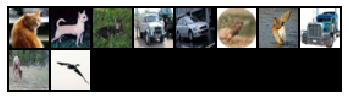

In [12]:
plt.imshow(img)
plt.axis('off')
plt.show()

#### Building our nn

In [13]:
import torch.nn as nn

In [14]:
# defining the depth for the 3 conv layers
# Pytorch infers automatically the width and height of the conv volume

in_size = 3
hidden_1_size = 16 
hidden_2_size = 32 
out_size = len(labels)
kernel_dim = 3 # what is this ?

In [15]:
class ConvNet (nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hidden_1_size, kernel_dim),
            nn.BatchNorm2d(hidden_1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_1_size, hidden_2_size, kernel_dim),
            nn.BatchNorm2d(hidden_2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # hidden_2_size is the detpth of the last volume, and kernel_size x kernel_size is
        # the dimension of the layer after 2 conv and 2 max pooling layers
        self.fc = nn.Linear(hidden_2_size * 6 * 6, out_size) 
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) # flatten the layer 
        out = self.fc(out)
        
        return out
        
    

In [16]:
model = ConvNet()

In [17]:
for hue in model.parameters():
    print(hue.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([10, 1152])
torch.Size([10])


In [18]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # the loss function
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [40]:
my_list = ['model.fc.weight', 'model.fc.bias']
params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))
optimizer = torch.optim.SGD([{'params': base_params}, {'params': params, 'lr': '1e-4'}], lr=3e-6, momentum=0.9)

#### Training the model

In [19]:
total_step = len(traindataloader)
num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(traindataloader):
        
        outputs = model(images) # processing a batch
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%2000 == 0:
            loss_history.append(loss.item())
            print('Epoch [{}/{}]  Step [{}/{}]  Loss {} '.format(
            epoch+1, num_epochs, i+1, total_step, loss.item() )) # here we get the current loss
            


Epoch [1/5]  Step [2000/5000]  Loss 1.5398621559143066 
Epoch [1/5]  Step [4000/5000]  Loss 1.122398853302002 
Epoch [2/5]  Step [2000/5000]  Loss 1.0322684049606323 
Epoch [2/5]  Step [4000/5000]  Loss 1.3775722980499268 
Epoch [3/5]  Step [2000/5000]  Loss 0.318933367729187 
Epoch [3/5]  Step [4000/5000]  Loss 1.3180798292160034 
Epoch [4/5]  Step [2000/5000]  Loss 0.5089459419250488 
Epoch [4/5]  Step [4000/5000]  Loss 0.4715821146965027 
Epoch [5/5]  Step [2000/5000]  Loss 1.2672401666641235 
Epoch [5/5]  Step [4000/5000]  Loss 0.9742493629455566 


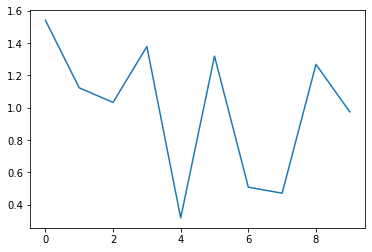

In [20]:

plt.plot(loss_history)
plt.show()

In [26]:
model.eval() # changes the state of the model to eval mode

with torch.no_grad():
    correct  = 0
    total = 0
    
    for images, labels in testdataloader:
        outputs = model(images)
        
        _ , predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the 10000 test images: 67.74%


tensor([[ -5.7816,  -4.9080,  -0.3902,  -0.0842,  -1.8724,   0.0196,  -1.4352,
          -0.6525,  -6.6500,  -6.0963],
        [ -6.9672,  -6.8928,  -0.5025,  -2.2630,   1.5185,  -3.1802,   0.5639,
          -0.4420,  -7.4662,  -7.3801],
        [ -1.3735,   2.8108,  -6.9943,  -9.1879,  -8.2382,  -9.4893, -11.6810,
          -5.4946,  -6.8010,   6.1632],
        [  0.3598,  -0.3567,  -5.0120,  -3.5647,  -2.9267,  -7.9244,  -7.7309,
          -4.4486,   4.6581,   0.3882],
        [ -7.2565,  -6.0613,  -3.9070,  -3.4072,   1.0263,  -2.8009,  -2.2802,
           3.1355,  -7.3109,  -4.6142],
        [ -1.3322,  -6.7420,  -2.0489,  -3.0772,   0.6791,  -3.0509,  -3.6441,
          -0.8045,  -5.1102,  -4.2800],
        [  0.3258,  -4.5374,  -1.2473,  -2.6359,  -0.7436,  -4.3764,  -2.5576,
          -3.5120,   2.6536,  -4.0105],
        [ -8.7334,  -5.6686,  -5.7539,   0.2560,  -2.5750,  -4.5007,  -3.3275,
          -4.2608,  -3.8598,  -1.8162],
        [ -4.2496,  -1.1041,  -1.9576,  -0.1508,